In [1]:
import numpy as np
import pandas as pd 
import lightgbm as lgb
import gc
from fastai.tabular import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime
from tqdm import tqdm_notebook

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [3]:
train = pd.read_csv('/kaggle/input/zindi-weekendz-pollution/Train.csv')
test = pd.read_csv('/kaggle/input/zindi-weekendz-pollution/Test.csv')
sample_sub = pd.read_csv('/kaggle/input/zindi-weekendz-pollution/SampleSubmission.csv')

In [4]:
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format='%Y-%m-%d')

In [5]:
ID_COL, TARGET_COL = 'Place_ID X Date', 'target'
df = pd.concat([train, test]).reset_index(drop=True)
features = [c for c in df.columns if c not in ['Date', 'target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID', 'target_max', 'target']]
df['placeID_freq'] = df['Place_ID'].map(df['Place_ID'].value_counts())

for i in tqdm_notebook(range(1, 20)):
    df[f'prev_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].fillna(method='ffill').shift(i).sort_index()
    df[f'next_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].fillna(method='bfill').shift(-i).sort_index()
    
for i in tqdm_notebook(range(1, 15)):
    df[f'magic_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(i).expanding().mean().fillna(method='ffill').sort_index()
    df[f'magic2_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(-i).expanding().mean().fillna(method='bfill').sort_index()
    
for i in tqdm_notebook(range(1, 45)):
    c = 'Date' + str(i+1)
    df[c] = df['Date']  + datetime.timedelta(days=i)
    _ = add_cyclic_datepart(df, c, prefix = c)
    
for i in tqdm_notebook(range(1, 11)):
    tmp = df.sort_values(by='Date').groupby('Place_ID')[features].shift(i).sort_index()
    tmp_diff_prev = df[features] - tmp
    tmp.columns = [c + f'_prev_{i}' for c in tmp.columns]
    tmp_diff_prev.columns = [c + f'_prev_diff_{i}' for c in tmp_diff_prev.columns]
    df = pd.concat([df, tmp, tmp_diff_prev], axis=1)
    
    tmp = df.sort_values(by='Date').groupby('Place_ID')[features].shift(-i).sort_index()
    tmp_diff_next = df[features] - tmp
    tmp.columns = [c + f'_next_{i}' for c in tmp.columns]
    tmp_diff_next.columns = [c + f'_next_diff_{i}' for c in tmp_diff_next.columns]
    df = pd.concat([df, tmp, tmp_diff_next], axis=1)
    
for attr in ['day', 'month', 'week', 'dayofweek', 'weekofyear', 'days_in_month', 'is_month_start', 'is_month_end', 'dayofyear']:
    df[attr] = getattr(df['Date'].dt, attr)
df['is_weekend'] = (df['dayofweek'] >= 5)*1
df['quarter'] = df['day']%15
df['which_quarter'] = df['day']//15

add_cyclic_datepart(df, "Date", prefix = "Current_Date_")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,...,quarter,which_quarter,Current_Date_weekday_cos,Current_Date_weekday_sin,Current_Date_day_month_cos,Current_Date_day_month_sin,Current_Date_month_year_cos,Current_Date_month_year_sin,Current_Date_day_year_cos,Current_Date_day_year_sin
0,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,1793.793579,3227.855469,0.010579,74.481049,...,2,0,-0.900969,0.433884,0.979530,0.201299,1.000000e+00,0.000000,0.999853,0.017166
1,-1.082553,840772.941995,-14.708036,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,...,3,0,-0.900969,-0.433884,0.918958,0.394356,1.000000e+00,0.000000,0.999411,0.034328
2,-1.001241,841410.713456,-105.201338,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,...,4,0,-0.222521,-0.974928,0.820763,0.571268,1.000000e+00,0.000000,0.998674,0.051479
3,-0.777023,841103.242368,-104.334056,29.180977,-73.896572,30.545393,NaN,NaN,NaN,NaN,...,5,0,0.623490,-0.781831,0.688967,0.724793,1.000000e+00,0.000000,0.997643,0.068615
4,0.366324,840763.055499,58.850179,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,...,6,0,1.000000,0.000000,0.528964,0.848644,1.000000e+00,0.000000,0.996318,0.085731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46688,-1.011116,833312.353691,63.241090,51.611371,-176.521720,38.857262,NaN,NaN,NaN,NaN,...,1,2,0.623490,0.781831,0.979530,-0.201299,5.000000e-01,0.866025,0.025748,0.999668
46689,-1.363941,833125.012462,-17.869847,55.065521,15.079379,40.886310,NaN,NaN,NaN,NaN,...,1,0,-0.222521,0.974928,1.000000,0.000000,6.123234e-17,1.000000,0.008583,0.999963
46690,-1.776128,832573.386814,-99.647714,27.132738,-152.254156,41.190326,NaN,NaN,NaN,NaN,...,2,0,-0.900969,0.433884,0.978148,0.207912,6.123234e-17,1.000000,-0.008583,0.999963
46691,-2.971064,832687.223024,38.739218,0.564620,-158.883352,39.431193,0.000000,0.000000,0.000000,0.000000,...,3,0,-0.900969,-0.433884,0.913545,0.406737,6.123234e-17,1.000000,-0.025748,0.999668


In [6]:
features = [c for c in df.columns if c not in ['Date', 'target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID',
                                               'target_max', 'target',  'month_year_cos','month_year_sin','day_year_cos','day_year_sin']]
train = df[:train.shape[0]].reset_index(drop=True)
test = df[train.shape[0]:].reset_index(drop=True)
target = train[TARGET_COL]
len(features)

3473

In [7]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 40, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.03,
         "boosting": "gbdt",
         "feature_fraction": 0.35,
         "metric": 'auc',
         "lambda_l1": 1,
         "lambda_l2": 1,
         "random_state": 6,
         "verbosity": -1,
          'metric' : 'rmse',
          'num_iterations': 1000}

In [8]:
target_cols = ['target']
oofs_df = pd.DataFrame()
preds_df = pd.DataFrame()
for t_col in target_cols:
    oofs_df[t_col] = np.zeros(len(train))
    preds_df[t_col] = np.zeros(len(test))

In [9]:
max_iter = 10
folds = StratifiedKFold(n_splits=max_iter, random_state=1901)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    print("\nfold n°{}".format(fold_))
    X_trn, X_val, X_test = train.iloc[trn_idx][features], train.iloc[val_idx][features], test[features]
    for t_col in target_cols:
        target = train[t_col]
        print(f"\n\n**** {t_col} ****\n")
        y_trn, y_val = target.iloc[trn_idx], target.iloc[val_idx]
        trn_data = lgb.Dataset(X_trn, y_trn)
        val_data = lgb.Dataset(X_val, y_val)
        
        clf = lgb.train(param, trn_data, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 200)

        oofs_df[t_col][val_idx] = clf.predict(X_val, num_iteration=clf.best_iteration)
        current_test_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
        current_test_pred[current_test_pred < 0] = 0
        preds_df[t_col] += current_test_pred / folds.n_splits

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



fold n°0


**** target ****



/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 16.5772	valid_1's rmse: 24.6498
[400]	training's rmse: 11.0103	valid_1's rmse: 23.8424
[600]	training's rmse: 8.01798	valid_1's rmse: 23.5598
[800]	training's rmse: 6.07825	valid_1's rmse: 23.4416
[1000]	training's rmse: 4.7085	valid_1's rmse: 23.3903
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 4.7085	valid_1's rmse: 23.3903

fold n°1


**** target ****

Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 15.2048	valid_1's rmse: 36.5936
[400]	training's rmse: 9.82813	valid_1's rmse: 36.1759
[600]	training's rmse: 7.0902	valid_1's rmse: 36.0666
[800]	training's rmse: 5.38455	valid_1's rmse: 35.9991
[1000]	training's rmse: 4.20044	valid_1's rmse: 35.9718
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 4.20044	valid_1's rmse: 35.9718

fold n°2


**** target ****

Training until validation scores don't improve for 200 roun

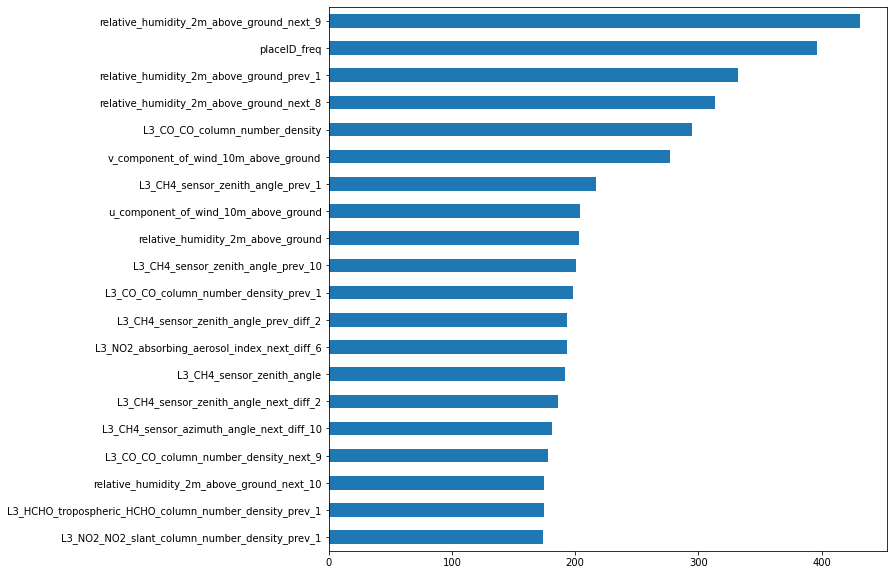

In [10]:
_ = plt.figure(figsize=(10, 10))
fi = pd.Series(index=features, data=clf.feature_importance())
_ = fi.sort_values()[-20:].plot(kind='barh')

In [11]:
rmse(target.values, oofs_df['target'].values)

27.423727753880286

In [12]:
predictions_test = preds_df['target']
predictions_test[predictions_test < 0] = 0

In [13]:
SUB_FILE_NAME = 'preds_lgbm_v2.csv'
sub_df = pd.DataFrame()
sub_df[ID_COL] = test[ID_COL]
sub_df[TARGET_COL] = predictions_test
sub_df.to_csv(SUB_FILE_NAME, index=False)
sub_df.head(10)

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,34.314782
1,0OS9LVX X 2020-01-03,30.029879
2,0OS9LVX X 2020-01-04,28.069904
3,0OS9LVX X 2020-01-05,33.653466
4,0OS9LVX X 2020-01-06,51.477208
5,0OS9LVX X 2020-01-07,46.432936
6,0OS9LVX X 2020-01-08,26.307917
7,0OS9LVX X 2020-01-09,28.565279
8,0OS9LVX X 2020-01-10,29.407409
9,0OS9LVX X 2020-01-11,36.728670


In [14]:
sub_df[TARGET_COL].describe()

count    16136.000000
mean        57.896735
std         35.183414
min          3.418439
25%         31.593047
50%         48.434942
75%         74.970675
max        269.771541
Name: target, dtype: float64